<a href="https://colab.research.google.com/github/obeshor/Plant-Diseases-Detector/blob/master/Plant_Diseases_Detection_with_TF2_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Disease Detection

The project is broken down into multiple steps:

* Building and creating a machine learning model using TensorFlow with Keras
* Deploying the model to an Android application using TFLite







## **Machine Learning  model using Tensorflow with Keras**

Designed models to recognize plant species and diseases in the crop leaves by using Convolutional Neural Network.


### **Importing  the Librairies**

In [10]:
# Install nightly package for some functionalities that aren't in alpha
!pip install --upgrade tensorflow-gpu

# Install TF Hub for TF2
!pip install --upgrade tensorflow-hub


In [8]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers




In [9]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)


Version:  2.7.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


### Load the data
Used a download dataset zip file (PlantVillage) for building the model. The PlantVillage dataset consists of 54303 healthy and unhealthy leaf images divided into 38 categories by species and disease.



### Prepare training and validation  dataset
Create the training and validation directories 
<br>Having a validation set provides great insight into whether your model is overfitting or not.

In [2]:
dataset_file = 'plantimages'
import os
data_dir = os.path.join(dataset_file, 'PlantDisease')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
print(os.getcwd())
print(train_dir)


C:\Users\20001695\Desktop\RP YR2 Sem 2\C200 Special Projects\PlantDisease
plantimages\PlantDisease\train


In [3]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [4]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))


total images for training : plantimages\PlantDisease\train : 43444files
total images for validation : plantimages\PlantDisease\val : 11004files


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `categories.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html).

Since a computer is unable to identify each category of plants based on their names (e.g. Apple_Black rot), it has to use integers to identify them instead. Thus, we use a dictionary mapping the integer encoded categories to the actual names of the plants and diseases.

In [35]:
pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=74926b4c584e47fa401ac48314564796fa25221b1b5884cee76b33ae90b563de
  Stored in directory: c:\users\20001695\appdata\local\pip\cache\wheels\04\5f\3e\46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
Note: you may need to restart the kernel to use updated packages.


In [5]:
import wget 
url = "https://github.com/obeshor/Plant-Diseases-Detector/archive/master.zip"
wget.download(url)

-1 / unknown

'Plant-Diseases-Detector-master.zip'

In [13]:
import zipfile
with zipfile.ZipFile('Plant-Diseases-Detector-master.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [14]:
import json

with open('Plant-Diseases-Detector-master/categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [15]:
print('Number of classes:', len(classes))

Number of classes: 38


### Setup Image shape and  batch size

In [16]:


IMAGE_SHAPE = (224, 224)

BATCH_SIZE = 64 #@param {type:"integer"}

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. 

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to process by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

Data augmentation is for increasing the diversity of data available for training models, without actually collecting new data. 

In [23]:
# Inputs are suitably resized for the selected module. 
# Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, #Sorts the data in alphanumerical order
    seed=42, #Random seed number for getting same results
    color_mode="rgb", #Images are in 24-bit RGB
    class_mode="categorical", #Determines the type of label arrays that are returned: "categorical" will be 2D one-hot encoded labels
    target_size=IMAGE_SHAPE, #Image size of the input images
    batch_size=BATCH_SIZE) #Size of the batches of data

do_data_augmentation = True #@param {type:"boolean"} 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255, # transform every pixel value from range [0,255] -> [0,1]
      rotation_range=40, #Degree range for random rotations.
      horizontal_flip=True, #Randomly flip inputs horizontally.
      width_shift_range=0.2, #float: fraction of total width, if < 1, or pixels if >= 1. If the value is float and <=1 it will take the percentage of total width as range. Shifts horizontally
      height_shift_range=0.2, #Shift vertically                              
      shear_range=0.2, #Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
      zoom_range=0.2, #Random zooming into the image
      fill_mode='nearest' ) #It sets rules for newly shifted pixel in the input area.
else:
  train_datagen = validation_datagen #If don't want data augmentation
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", #Subset of data ("training" or "validation")
    shuffle=True, #Sorts the data in alphanumerical order
    seed=42, #Random seed number for getting same results
    color_mode="rgb", #Images are in 24-bit RGB
    class_mode="categorical", #Determines the type of label arrays that are returned: "categorical" will be 2D one-hot encoded labels
    target_size=IMAGE_SHAPE, #Image size of the input images
    batch_size=BATCH_SIZE) #Size of the batches of data


Found 10861 images belonging to 38 classes.
Found 43444 images belonging to 38 classes.


### Build the model
All it takes is to put a linear classifier on top of the feature_extractor_layer with the Hub module.

For speed, we start out with a non-trainable feature_extractor_layer, but you can also enable fine-tuning for greater accuracy.

In [24]:

model = tf.keras.Sequential([ #Sequential groups a linear stack of layers into a tf.keras.Model.
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", #This layer wraps a callable object for use as a Keras layer. Preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.
                 output_shape=[1280], #Outputs a tensor with shape [batch_size, 1280].
                 trainable=False), #A boolean controlling whether this layer is trainable.               
  tf.keras.layers.Dropout(rate=0.4), #Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. 
  tf.keras.layers.Dense(512, activation='relu'), #Positive integer, dimensionality of the output space. Rectified Linear Unit activation function
  tf.keras.layers.Dropout(rate=0.2),  
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax') #Softmax calculates the probability for the results
])


### Specify Loss Function and Optimizer
Adam is an adaptive learning rate method, which means, it computes individual learning rates for different parameters.
The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated.

In [25]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile( #Configure the model for training
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),  #Optimizer that implements the Adam algorithm. 
   loss='categorical_crossentropy', #Used as a loss function for multi-class classification model where there are two or more output labels. 
   metrics=['accuracy']) #List of metrics to be evaluated by the model during training and testing.



### Train Model
train model using validation dataset for validate each steps
<br> epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset

In [26]:

EPOCHS=10 #@param {type:"integer"}

history = model.fit_generator(
        train_generator, 
        steps_per_epoch=train_generator.samples//train_generator.batch_size, #specifies the total number of steps taken from
                                                                             #the generator as soon as one epoch is finished
                                                                             #and next epoch has started.
        epochs=EPOCHS, #number of epochs we want to train our model for.
        validation_data=validation_generator, #used to evaluate the loss and metrics for any model after any epoch has ended.
        validation_steps=validation_generator.samples//validation_generator.batch_size) #specifies the total number of steps
                                                                                        #taken from the generator before it 
                                                                                        #is stopped at every epoch and its 
                                                                                        #value is calculated

C:\Users\20001695\AppData\Local\Temp/ipykernel_33700/1892291988.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
678/678 [==============================] - 737s 1s/step - loss: 0.7519 - accuracy: 0.7765 - val_loss: 0.2815 - val_accuracy: 0.9129
Epoch 2/10
678/678 [==============================] - 724s 1s/step - loss: 0.4383 - accuracy: 0.8577 - val_loss: 0.2433 - val_accuracy: 0.9223
Epoch 3/10
678/678 [==============================] - 740s 1s/step - loss: 0.3975 - accuracy: 0.8686 - val_loss: 0.2371 - val_accuracy: 0.9223
Epoch 4/10
678/678 [==============================] - 775s 1s/step - loss: 0.3691 - accuracy: 0.8803 - val_loss: 0.2167 - val_accuracy: 0.9280
Epoch 5/10
678/678 [==============================] - 785s 1s/step - loss: 0.3494 - accuracy: 0.8871 - val_loss: 0.2001 - val_accuracy: 0.9315
Epoch 6/10
678/678 [==============================] - 768s 1s/step - loss: 0.3438 - accuracy: 0.8880 - val_loss: 0.2037 - val_accuracy: 0.9313
Epoch 7/10
678/678 [==============================] - 763s 1s/step - loss: 0.3276 - accuracy: 0.8921 - val_loss: 0.1999 - val_accuracy: 0.9361

### Check Performance
Plot training and validation accuracy and loss

### Random test
Random sample images from validation dataset and predict
<br>Graphs are to check for overfitting (perform well with training dataset but bad for validation dataset)

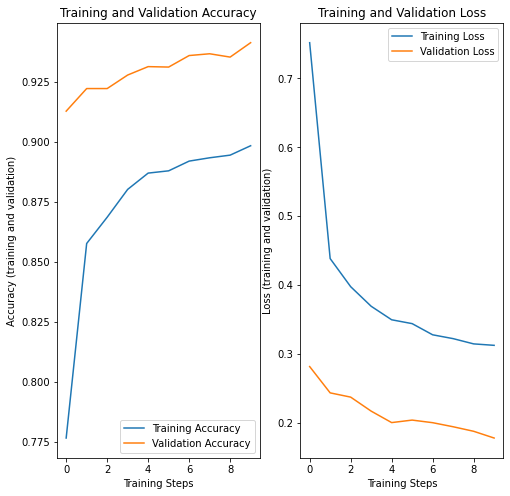

In [27]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy'] #Recorded accuracy for training
val_acc = history.history['val_accuracy'] #Recorded accuracy for validation

loss = history.history['loss'] #Recorded loss for training
val_loss = history.history['val_loss'] #Recorded loss for validation

epochs_range = range(EPOCHS) #0-10

plt.figure(figsize=(8, 8)) #Display of both graphs in Width, height (inches).
plt.subplot(1, 2, 1) #1st parameter: 1 row, 2nd parameter: 2 columns, 3rd paramter: specifies which column to use
plt.plot(epochs_range, acc, label='Training Accuracy') #x-axis: 0-10, y-axis: acc, label: name of line
plt.plot(epochs_range, val_acc, label='Validation Accuracy')#y-axis: val_acc
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [31]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [37]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(validation_dir, filename))  #loads an image from the specified file.
    img = cv2.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]) ) #resize height and width to 224 and 224 respectively
    img = img /255 #Converts images to range from 0 to 1.
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0] #predict the labels of the data values on the basis of the trained model
    class_idx = np.argmax(probabilities) #predicted class category
    
    return {classes[class_idx]: probabilities[class_idx]}

In [3]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)): #retrieves 5 random files, emunerate retrieves index and filename e.g. (1, file1)
    print("SOURCE - class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED - class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

NameError: name 'random' is not defined

## Export as saved model and convert   to TFLite

In [42]:
saved_model_path = "./model" # or you can simply use 'my_mode.h5'
model.save(saved_model_path) #save your model 


INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


In [44]:
# to reload your model 
reloaded = tf.keras.models.load_model(saved_model_path)

In [45]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), file: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)\2ffbfc4d-d3c2-4cc1-a2a7-567413630247___FAM_L.Blight 4711.JPG
PREDICTED: class: Grape___Black_rot, confidence: 0.984939


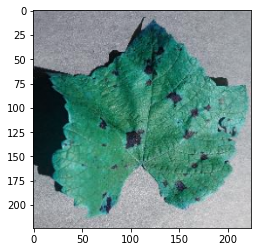

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___Tomato_Yellow_Leaf_Curl_Virus, file: Tomato___Tomato_Yellow_Leaf_Curl_Virus\cc069405-6ea8-432d-8855-db7253f29e76___UF.GRC_YLCV_Lab 08459.JPG
PREDICTED: class: Tomato___Spider_mites Two-spotted_spider_mite, confidence: 0.368616


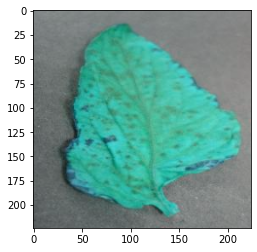

In [46]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)  
    plt.show()

## Convert Concrete Function to TFLite

In [47]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/plant_disease_model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

11647520

## Convert SavedModel to TFLite

In [49]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

## Convert SavedModel to ONNX

In [17]:
pip install tflite2onnx

Note: you may need to restart the kernel to use updated packages.


In [19]:
import tflite2onnx

tflite_path = './tflite_models/model.tflite'
onnx_path = './onnx_model/model'

tflite2onnx.convert(tflite_path, onnx_path)

In [2]:
import trtexec

ModuleNotFoundError: No module named 'trtexec'

SyntaxError: cannot assign to operator (Temp/ipykernel_604/937299634.py, line 1)